<a href="https://www.kaggle.com/code/zeeshanahmadyar/human-decision-failure-simulator-burnout-predictin?scriptVersionId=290578976" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Import Libraries for *Project***

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_decision_regions
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/human-behavior-burnout-dataset/Human Behavior Burnout Dataset.csv


# Import dataset

In [2]:
df = pd.read_csv('/kaggle/input/human-behavior-burnout-dataset/Human Behavior Burnout Dataset.csv')
df.head()

,age,income,screen_time,sleep_hours,stress_level,burnout
0,35,50692,6.91,7.10,9,0
1,43,147030,2.10,6.76,3,0
2,27,83226,2.29,7.79,1,0
3,36,88827,4.99,7.20,3,0
4,30,90204,2.03,7.35,6,0


# **Check Outliers**

<Axes: ylabel='screen_time'>

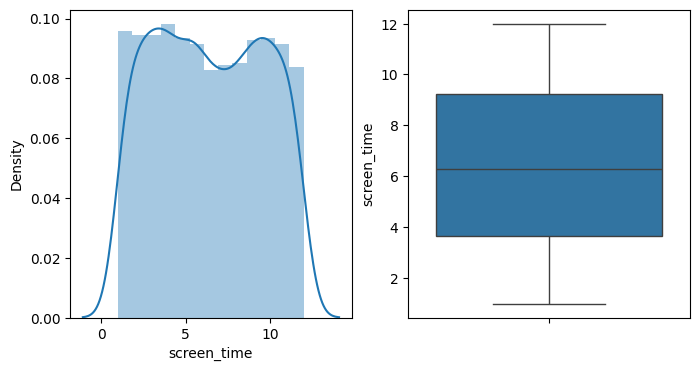

In [3]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
sns.distplot(df['screen_time'])

plt.subplot(1, 2, 2)
sns.boxplot(df['screen_time'])

# **Check Missing Values** 

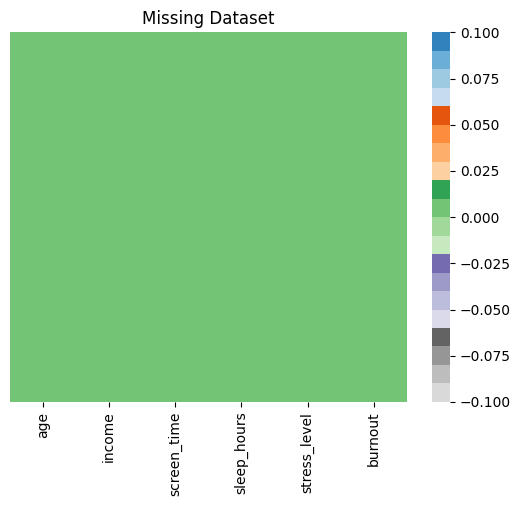

In [4]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=True, cmap='tab20c_r' )
plt.title('Missing Dataset')
plt.show()

In [5]:
X = df.drop('burnout', axis=1)
y = df['burnout']

In [6]:
X.shape
y.shape

(2000,)

<Axes: xlabel='income', ylabel='screen_time'>

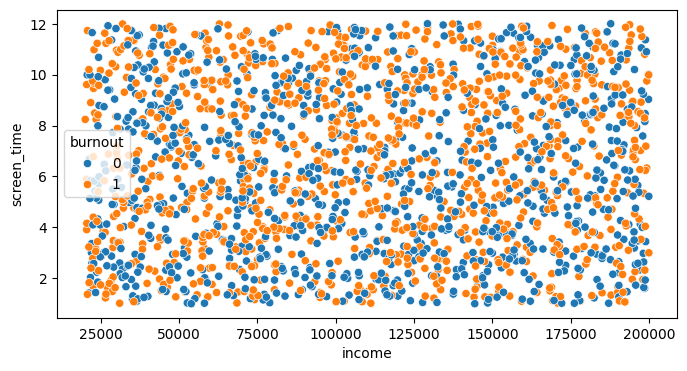

In [7]:
plt.figure(figsize=(8, 4))
sns.scatterplot(x=df['income'], y=df['screen_time'], hue=df['burnout'])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
scaler = StandardScaler()

In [10]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# **Initialize Decision Stump with max depth: 1**

In [12]:
# weak learner: Decision Stump (max_depth=1)
stump = DecisionTreeClassifier(max_depth=1, random_state=42)

In [13]:
stump.fit(X_train_scaled, y_train)

DecisionTreeClassifier(max_depth=1, random_state=42)

# **Make Prediction**

In [14]:
y_pred = stump.predict(X_test_scaled)

In [15]:
print("Weak Lerner Accuracy:", accuracy_score(y_test, y_pred))

Weak Lerner Accuracy: 0.6066666666666667


# **AdaBoostClassifier with 50 weak learners**

In [16]:
ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=0.5,
    random_state=42
)

In [17]:
ada.fit(X_train_scaled, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=100, random_state=42)

In [18]:
y_pred_ada = ada.predict(X_test_scaled)

In [19]:
print('AdaBoostClassifier Accuracy:', accuracy_score(y_test, y_pred_ada))

AdaBoostClassifier Accuracy: 0.6016666666666667


# **Visualize sample weights / Iteration Learning**

In [20]:
stumps = ada.estimators_
estimator_weights = ada.estimator_weights_

print('Stumps:', stumps[0])
print('Estimator Weights' , estimator_weights[0])

Stumps: DecisionTreeClassifier(max_depth=1, random_state=1608637542)
Estimator Weights 0.2508465701013592


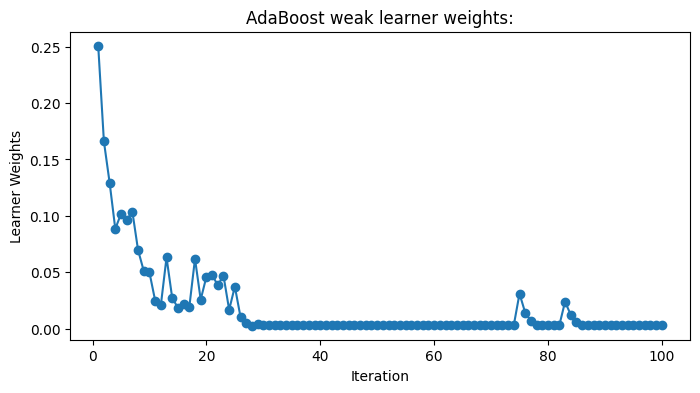

In [21]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(estimator_weights) + 1), estimator_weights, marker='o')
plt.title('AdaBoost weak learner weights:')
plt.xlabel('Iteration')
plt.ylabel('Learner Weights')
plt.show()

# **MisClassified samples Evaluation**

In [22]:
errors = []
for y_pred_iter, alpha in zip(ada.staged_predict(X_test), ada.estimator_weights_):
    errors.append(np.mean(y_pred_iter != y_test))

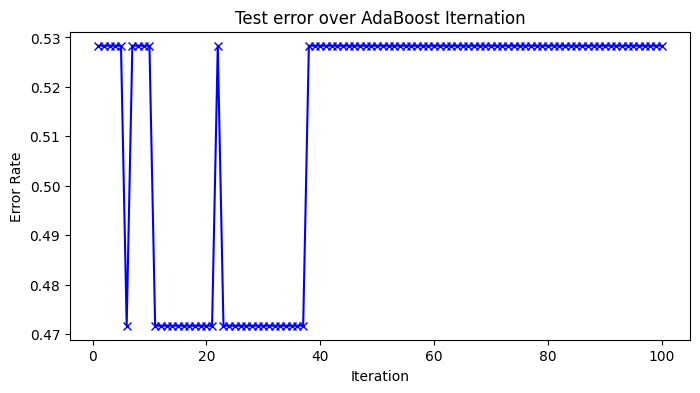

In [23]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(errors) + 1), errors, marker='x', color='b')
plt.title('Test error over AdaBoost Iternation')
plt.xlabel('Iteration')
plt.ylabel('Error Rate')
plt.show()

# **Finding Best Hyperparameters for AdaBoost**

In [24]:
parameters = {
    'n_estimators': [50, 100, 150, 200, 250],
    'learning_rate': [0.1, 0.3, 0.5, 1.0, 2]
}

In [25]:
grid_search = GridSearchCV(ada, parameters, cv=10, n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


GridSearchCV(cv=10,
             estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                                          learning_rate=0.5, n_estimators=100,
                                          random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.3, 0.5, 1.0, 2],
                         'n_estimators': [50, 100, 150, 200, 250]},
             verbose=1)

In [26]:
grid_search.best_params_

{'learning_rate': 0.5, 'n_estimators': 100}